# Playing with a model

In this notebook, we will use a Conditional Diffusion model to generate designs.

## Preliminaries

First let's make sure we have the necessary packages installed. Be sure to create a virtual environment, then install the required packages for this project in it.

In [4]:
!pip install -e .

Obtaining file:///Users/ffelte/Documents/EngiLearn
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/mdolab/pyoptsparse to /private/var/folders/fw/69hmbxm946l1xycg8w29nw0800l9gd/T/pip-install-f89x5s5_/pyoptsparse_d30cd54894d5404ba70e7fae5d361a3e
  Running command git clone --filter=blob:none --quiet https://github.com/mdolab/pyoptsparse /private/var/folders/fw/69hmbxm946l1xycg8w29nw0800l9gd/T/pip-install-f89x5s5_/pyoptsparse_d30cd54894d5404ba70e7fae5d361a3e
  Resolved https://github.com/mdolab/pyoptsparse to commit 9d417c740693dc706fef8ff2c064837fea04ec50
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Building editable for engiopt (pyproject.toml) ... done
  Created wheel for engiopt: filename=engiopt-0.0.1-0.edit

In [28]:
# Some imports we will need
import os

from diffusers import UNet2DConditionModel
import matplotlib.pyplot as plt
import numpy as np
import torch as th

from engiopt import metrics
from engiopt.diffusion_2d_cond.diffusion_2d_cond import beta_schedule
from engiopt.diffusion_2d_cond.diffusion_2d_cond import DiffusionSampler
import wandb


Let's make sure we can interact with the problem in EngiBench.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

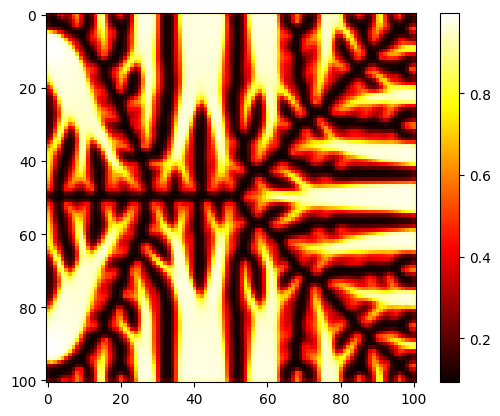

In [8]:
from engibench.problems.heatconduction2d import HeatConduction2D

problem = HeatConduction2D()
design, _ = problem.random_design()
problem.render(design)


## Training a model

In EngiOpt, we have a collection of models that can be used to generate designs.

Each model is defined under a dedicated folder in the `engiopt` package.

For example, the `diffusion_2d_cond` folder contains the code for the Conditional Diffusion model.

In each model folder, there are two scripts; one for training the model, and one for evaluating the model.

To train a model, we can use the `diffusion_2d_cond.py` script. There is a command line interface that can be used to specify the model parameters.

To see the available options, we can use the `-h` flag.


In [3]:
!python engiopt/diffusion_2d_cond/diffusion_2d_cond.py -h

/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
usage: diffusion_2d_cond.py [-h] [OPTIONS]

Command-line arguments.

╭─ options ──────────────────────────────────────────────────────────────────╮
│ -h, --help              show this help message and exit                    │
│ --problem-id STR        Problem identifier. (default: beams2d)             │
│ --algo STR              The name of this algorithm. (default:              │
│                         diffusion_2d_cond)                                 │
│ --track, --no-track     Track the experiment with wandb. (default: True)   │
│ --wandb-project STR     Wan

Now, let's say we want to train the model for the heat conduction problem, use weights and biases to track the training process, and save the resulting model in wandb. The resulting command would look like this:

In [4]:
!python engiopt/diffusion_2d_cond/diffusion_2d_cond.py --problem-id "heatconduction2d" --track --wandb-entity None --save-model --n-epochs 200 --seed 1

/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
wandb: Currently logged in as: florian-felten (engibench) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.10
wandb: Run data is saved locally in /Users/ffelte/Documents/EngiLearn/wandb/run-20250709_094019-9lgcuj7t
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run heatconduction2d__diffusion_2d_cond__1__1752046819
wandb: ⭐️ View project at https://wandb.ai/engibench/engiopt
wandb: 🚀 View run at https://wandb.ai/engibench/engiopt/runs/9lgcuj7t
^C
Traceback (most recent call last):
  Fil

## Restoring a model and using it to generate designs

Now we can: 
1. Download a model from wandb
2. Use the model to generate designs

In [9]:
## Downloading a model from wandb
problem_id = "heatconduction2d"
seed = 1

# This is the name of the model in wandb, for the sake of the example we will use a model that is stored on the official engiopt wandb project. If you want to use a model that you trained yourself, you can change the artifact_path to the path of your model.
artifact_path = f"engibench/engiopt/{problem_id}_diffusion_2d_cond_model:seed_{seed}"

api = wandb.Api()
artifact = api.artifact(artifact_path, type="model")
artifact_dir = artifact.download()
ckpt_path = os.path.join(artifact_dir, "model.pth")
device = th.device("cuda" if th.cuda.is_available() else "cpu")
ckpt = th.load(ckpt_path, map_location=device)

# We will also need the "run" object to get the model configuration which was used to train the model.
run = artifact.logged_by()

# This is the model definition that was used to train the model. You can find the definition in the engiopt/diffusion_2d_cond/diffusion_2d_cond.py file.
model = UNet2DConditionModel(
    sample_size=problem.design_space.shape,
    in_channels=1,
    out_channels=1,
    cross_attention_dim=64,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
    layers_per_block=run.config["layers_per_block"],
    transformer_layers_per_block=1,
    encoder_hid_dim=len(problem.conditions),
    only_cross_attention=True,
).to(device)

model.load_state_dict(ckpt["model"])
model.eval()

# The noise schedule also must be restored
options = {
    "cosine": run.config["noise_schedule"] == "cosine",
    "exp_biasing": run.config["noise_schedule"] == "exp",
    "exp_bias_factor": 1,
}
betas = beta_schedule(
    t=run.config["num_timesteps"],
    start=1e-4,
    end=0.02,
    scale=1.0,
    options=options,
)
ddm_sampler = DiffusionSampler(run.config["num_timesteps"], betas)



wandb: Downloading large artifact heatconduction2d_diffusion_2d_cond_model:seed_1, 200.90MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4
/var/folders/fw/69hmbxm946l1xycg8w29nw0800l9gd/T/ipykernel_88800/2524680856.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full con

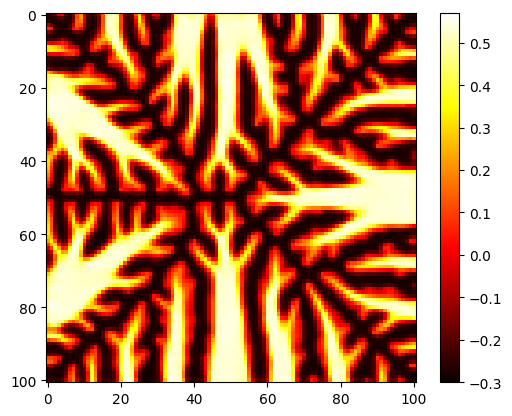

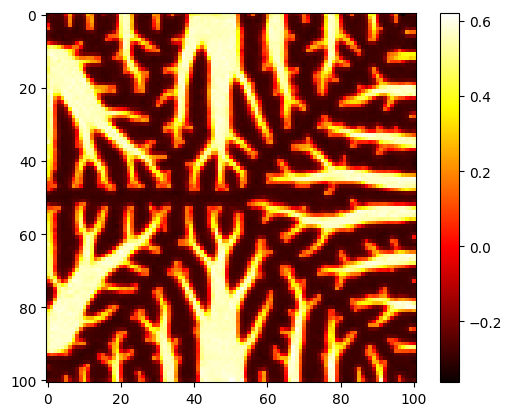

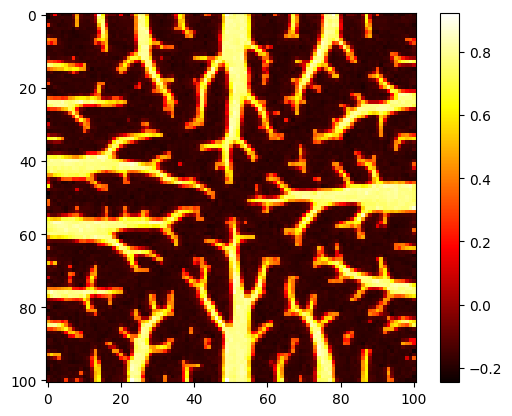

In [20]:
# Now we can use the model to generate designs
n_samples = 3

conditions = [
    {"volume": 0.5, "length": 0.5},
    {"volume": 0.4, "length": 0.7},
    {"volume": 0.2, "length": 0.1},
]

conditions_tensor = th.tensor([list(c.values()) for c in conditions], device=device)
conditions_tensor = conditions_tensor.unsqueeze(1) # Add channel dim

design_shape = problem.design_space.shape
# Denoise the designs in batch
gen_designs = th.randn((n_samples, 1, *design_shape), device=device)
for i in reversed(range(run.config["num_timesteps"])):
    t = th.full((n_samples,), i, device=device, dtype=th.long)
    gen_designs = ddm_sampler.sample_timestep(model, gen_designs, t, conditions_tensor)

gen_designs = gen_designs.cpu().numpy()

# Render the designs
for i in range(n_samples):
    problem.render(gen_designs[i][0]) # 0 removes the channel dim

## Evaluating the model

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.906e-05 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.931e-17 (tol = 1.000e-07) r (rel) = 4.977e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

List of options:

                                    Name   Value                # times used
                          acceptable_tol = 0.001                     1
                        file_print_level = 5                         1
                   hessian_approximation = limited-memory            

rm: cannot remove '/home/fenics/shared/templates/RES_OPT/TEMP*': No such file or directory


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.909e-05 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.748e-16 (tol = 1.000e-07) r (rel) = 1.764e-12 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

List of options:

                                    Name   Value                # times used
                          acceptable_tol = 0.001                     1
                        file_print_level = 5                         1
                   hessian_approximation = limited-memory            

rm: cannot remove '/home/fenics/shared/templates/RES_OPT/TEMP*': No such file or directory


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.901e-05 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.825e-17 (tol = 1.000e-07) r (rel) = 4.873e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

List of options:

                                    Name   Value                # times used
                          acceptable_tol = 0.001                     1
                        file_print_level = 5                         1
                   hessian_approximation = limited-memory            

rm: cannot remove '/home/fenics/shared/templates/RES_OPT/TEMP*': No such file or directory


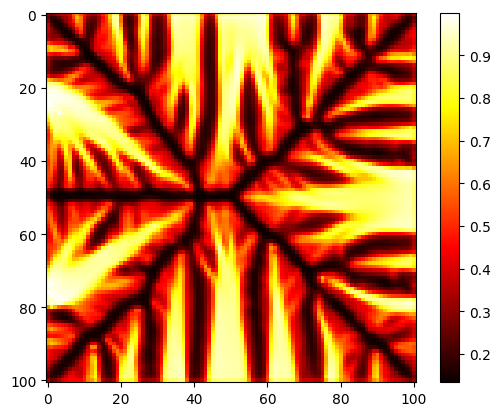

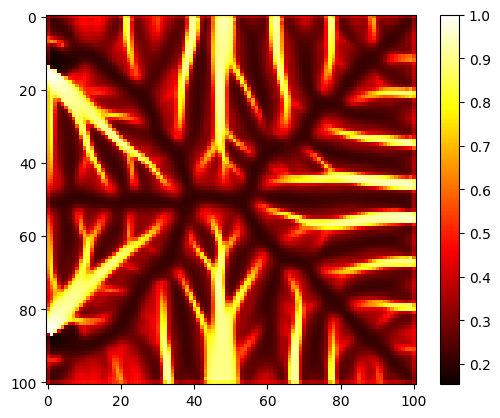

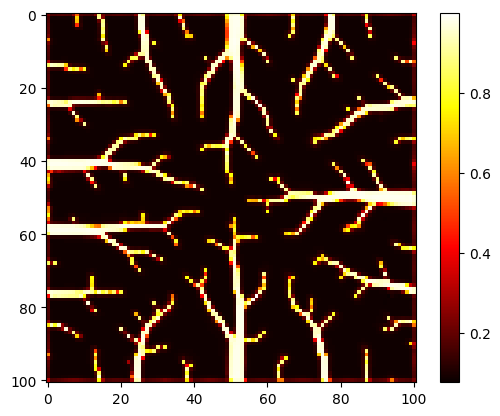

In [24]:

# Let's first optimize the generated designs, to see how far away they are from optimal designs
opt_designs = []
opt_histories = []
for i in range(n_samples):
    opt_design, opt_history = problem.optimize(
        starting_point=gen_designs[i][0],
        config=conditions[i],
    )
    opt_histories.append(opt_history)
    opt_designs.append(opt_design)

## Eyeball testing the model

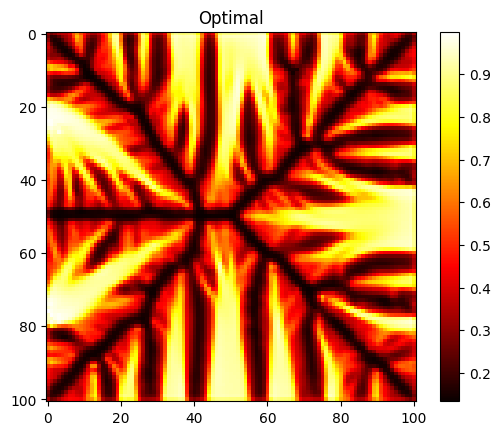

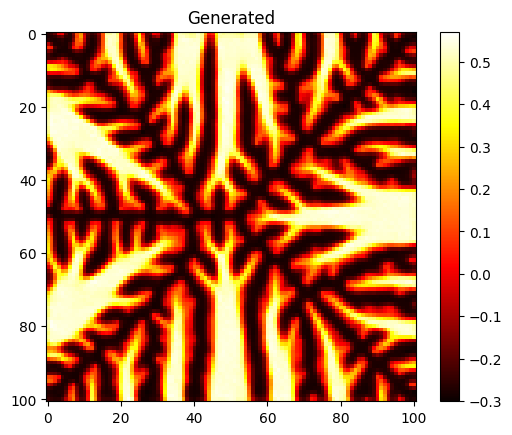

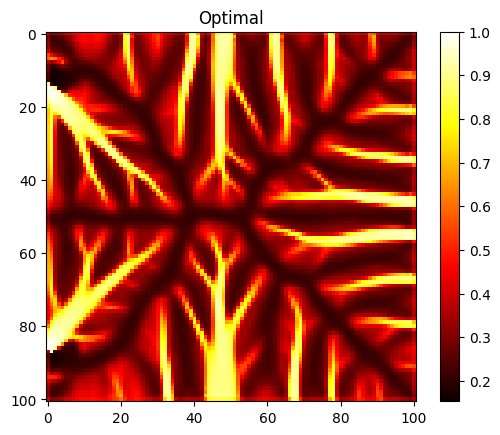

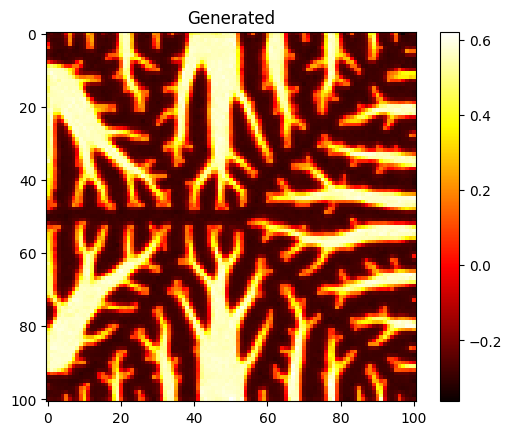

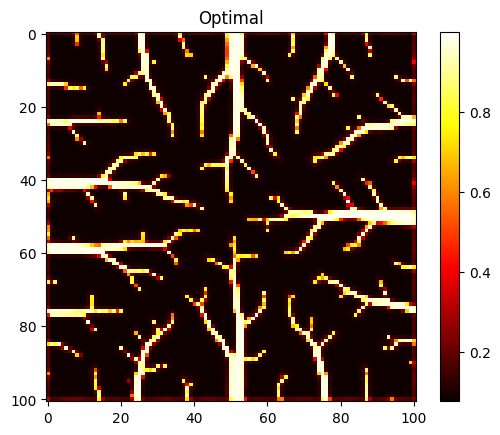

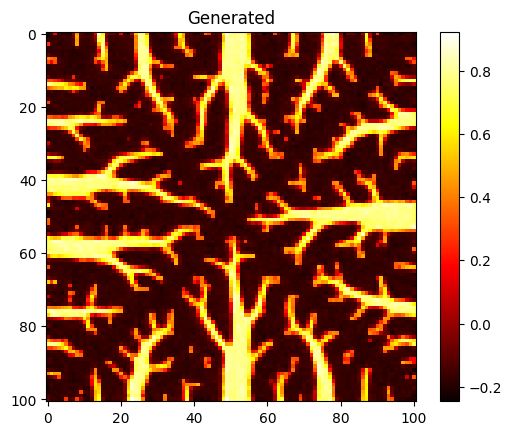

In [ ]:
# Render the optimal designs next to the generated designs to get a visual idea
for i in range(n_samples):
    fig_opt, ax_opt = problem.render(opt_designs[i])
    fig_gen, ax_gen = problem.render(gen_designs[i][0])
    ax_opt.set_title("Optimal")
    ax_gen.set_title("Generated")
    plt.show()

## Qualitative evaluation

In [44]:
# Now we can also use metrics to get a quantitative idea of how good the generated designs are
# Here we compute the average optimality gap, the cumulative optimality gap, and the final optimality gap
objective_values_opt = [problem.simulate(opt_designs[i], config=conditions[i]) for i in range(n_samples)]
optimality_gaps = [metrics.optimality_gap(opt_histories[i], baseline=objective_values_opt[i]) for i in range(n_samples)]

iog = [optimality_gaps[i][0] for i in range(n_samples)]
cog = [np.sum(optimality_gaps[i]) for i in range(n_samples)]
fog = [optimality_gaps[i][-1] for i in range(n_samples)]

print(f"Initial optimality gaps: {iog}")
print(f"Cumulative optimality gaps: {cog}")
print(f"Final optimality gaps: {fog}")

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.906e-05 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.392e-17 (tol = 1.000e-07) r (rel) = 3.425e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

List of options:

                                    Name   Value                # times used
                          acceptable_tol = 0.001                     1
                   hessian_approximation = limited-memory            7
                                max_iter = 0                         

rm: cannot remove '/home/fenics/shared/templates/RES_SIM/TEMP*': No such file or directory


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.909e-05 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.834e-17 (tol = 1.000e-07) r (rel) = 4.878e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

List of options:

                                    Name   Value                # times used
                          acceptable_tol = 0.001                     1
                   hessian_approximation = limited-memory            7
                                max_iter = 0                         

rm: cannot remove '/home/fenics/shared/templates/RES_SIM/TEMP*': No such file or directory


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.901e-05 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.361e-17 (tol = 1.000e-07) r (rel) = 5.415e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

List of options:

                                    Name   Value                # times used
                          acceptable_tol = 0.001                     1
                   hessian_approximation = limited-memory            7
                                max_iter = 0                         

rm: cannot remove '/home/fenics/shared/templates/RES_SIM/TEMP*': No such file or directory
